In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import random

In [2]:
import time
import math
from scipy.stats import halfnorm, norm
from sklearn.utils import shuffle

from gym import error, spaces, utils
from gym.utils import seeding

# RL

In [3]:
env = gym.make('ElectricCars:electric-v0')

/Users/iremaltiner/Desktop/RLStudySession/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
def create_bins(num_bins_per_obs=60):#every obs above will have 60 bins. Like energy_capacity is in [0, 60], divide by 60
    bins_energy_capacity = np.linspace(0.0,60.001,num_bins_per_obs)
    bins_tank_size = np.linspace(59.8,60.001,num_bins_per_obs) 
    
    bins = np.array([bins_tank_size, bins_energy_capacity])
    
    return bins

In [5]:
NUM_BINS = 60
BINS = create_bins(NUM_BINS)

In [6]:
def discretize_obs(observations,bins):
    binned_observations = []
    
    for i,obs in enumerate(observations):
        discretized_obs = np.digitize(obs, bins[i])
        binned_observations.append(discretized_obs)
    return tuple(binned_observations)

In [7]:
q_table = np.load('q_table110823FinalFinal.npy')

In [8]:
observation = env.reset()
rewards = 0
tank_size_list = []
charge_list = []
my_dict = {'Charger Type': [], 'Charging Time': [], 'Original Charger Type': [], 'Original Charging Time':[],
           'Cost': [], 'Charge Before Charging':[], 
          'Battery Size Before Charging': [], 'Charge After Charging':[], 'Reward':[]}

total_cost = 0
total_cost_list = []

for _ in range(365):
    discrete_state = discretize_obs(observation, BINS)  # get bins
    action = np.argmax(q_table[discrete_state])# and chose action from the Q-Table
    observation, reward, done, info = env.step(action) # Finally perform the action
    rewards = rewards + reward
    my_dict['Reward'].append(reward)
    my_dict['Charge After Charging'].append(info['ChargAftCharging'])
    my_dict['Battery Size Before Charging'].append(observation[0])
    my_dict['Charge Before Charging'].append(observation[1])
    my_dict['Cost'].append(info['Cost'])
    my_dict['Original Charger Type'].append(int(info['OrAct']/14))
    my_dict['Original Charging Time'].append(info['OrAct'] % 14)
    my_dict['Charger Type'].append(int(info['ChargType']/14))
    my_dict['Charging Time'].append(info['ChargType'] % 14)
    total_cost += info['Cost']
    total_cost_list.append(total_cost)
    tank_size_list.append(observation[0])
    
        
    print(f'State:{observation}; Total rewards: {rewards}; info:{info}, done:{done}, total_cost: {total_cost}')
    if done:
        print(f"You got {rewards} points!")
        break
env.close()

State:[60.       24.802422]; Total rewards: 70.001; info:{'Day': 1, 'ChargType': 1, 'OrAct': 1, 'ChargAftCharging': 24.80242222146822, 'Cost': 0}, done:False, total_cost: 0
State:[60.       11.841029]; Total rewards: 139.5328; info:{'Day': 2, 'ChargType': 15, 'OrAct': 15, 'ChargAftCharging': 15.441029369524093, 'Cost': 0.468}, done:False, total_cost: 0.468
State:[59.99988    1.7141042]; Total rewards: 207.5564; info:{'Day': 3, 'ChargType': 29, 'OrAct': 29, 'ChargAftCharging': 16.914104165347794, 'Cost': 1.976}, done:False, total_cost: 2.444
State:[59.99964    2.8180835]; Total rewards: 275.6842; info:{'Day': 4, 'ChargType': 21, 'OrAct': 23, 'ChargAftCharging': 17.218083524700667, 'Cost': 1.872}, done:False, total_cost: 4.316
State:[59.99952  14.661438]; Total rewards: 340.74379999999996; info:{'Day': 5, 'ChargType': 32, 'OrAct': 32, 'ChargAftCharging': 52.6614381533751, 'Cost': 4.9399999999999995}, done:False, total_cost: 9.256
State:[59.99928  43.082325]; Total rewards: 408.5441956615

/Users/iremaltiner/Desktop/RLStudySession/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/iremaltiner/Desktop/RLStudySession/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/iremaltiner/Desktop/RLStudySession/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/iremaltiner/Desktop/RLStudySession/lib/python3.9/s

# No RL Level 2

In [9]:
np.random.seed(101)
mu = 9
sigma = 1.15
X2 = halfnorm.rvs(loc = 0, scale = 0.2, size=20)
X1 = np.random.normal(mu, sigma, 345)
X = np.concatenate([X1,X2])
X[X < 1] = 0
Y = shuffle(X, random_state=101)

In [10]:
np.random.seed(101)
DayLog = np.random.gamma(shape=1.92, scale=15.20, size=365)
EConsLog = np.random.uniform(low=13, high=25.3, size=365)
DayLog[0]

121.9313242792982

In [11]:
observation = env.reset()
tank_size_list_L2 = []
charge_list_L2 = []
total_cost_L2 = 0
daily_cost_list_L2 = []
fullchargneed = 0
charge_after_charging = 0
full_charg = 0
total_cost_list_L2 = []

for i in range(365):
    observation[1] = observation[1] - (EConsLog[i]/62.137)*DayLog[i]
    state_bef_charging = np.array([observation[0], observation[1]])
    tank_size_list_L2.append(observation[0])
    fullchargneed = observation[0]-observation[1]
    if Y[i] != 0:
        observation[0] = observation[0] - (0.0004/100)*(observation[0])
    
    if Y[i]*7.6 > fullchargneed:
        observation[1] = observation[0]
        daily_cost_list_L2.append(fullchargneed*0.13)
        total_cost_L2 = total_cost_L2 + fullchargneed*0.13
        full_charg += 1
    else:
        observation[1] = observation[1] + 7.6*Y[i]
        daily_cost_list_L2.append(Y[i]*0.13*7.6)
        total_cost_L2 = total_cost_L2 + 7.6*0.13*Y[i]
    
    total_cost_list_L2.append(total_cost_L2)
    state_aft_charging = np.array([observation[0], observation[1]])
    print(f'State:{state_bef_charging}, State After Charging:{state_aft_charging}, Cost:{daily_cost_list_L2[i]}, Total Cost:{total_cost_L2}, Day:{i+1}')
print(full_charg)


State:[60.       24.802422], State After Charging:[59.99976 59.99976], Cost:4.575685195922851, Total Cost:4.575685195922851, Day:1
State:[59.99976 47.03837], State After Charging:[59.99952 59.99952], Cost:1.6849808883666992, Total Cost:6.26066608428955, Day:2
State:[59.99952  46.272594], State After Charging:[59.99928 59.99928], Cost:1.7845002365112306, Total Cost:8.045166320800782, Day:3
State:[59.99928 45.90326], State After Charging:[59.99904 59.99904], Cost:1.832482566833496, Total Cost:9.877648887634278, Day:4
State:[59.99904  57.442394], State After Charging:[59.9988 59.9988], Cost:0.3323637771606445, Total Cost:10.210012664794922, Day:5
State:[59.9988   50.419685], State After Charging:[59.998558 59.998558], Cost:1.2452846908569337, Total Cost:11.455297355651856, Day:6
State:[59.998558 48.18204 ], State After Charging:[59.998318 59.998318], Cost:1.5361471939086915, Total Cost:12.991444549560548, Day:7
State:[59.998318 55.0526  ], State After Charging:[59.998077 59.998077], Cost:

# No RL DC

In [12]:
observation = env.reset()
tank_size_list_DC = []
charge_list_DC = []
total_cost_DC = 0
daily_cost_list_DC = []
fullchargneed = 0
charge_after_charging = 0
charge_to_full = 0
total_cost_list_DC = []

for i in range(365):
    observation[1] = observation[1] - (EConsLog[i]/62.137)*DayLog[i]
    state_bef_charging = np.array([observation[0], observation[1]])
    tank_size_list_DC.append(observation[0])
    fullchargneed = observation[0]-observation[1]
    if Y[i] != 0:
        observation[0] = observation[0] - (0.0006/100)*(observation[0])
    
    if Y[i]*60 > fullchargneed:
        observation[1] = observation[0]
        daily_cost_list_DC.append(fullchargneed*0.26)
        total_cost_DC = total_cost_DC + fullchargneed*0.26
        print(f'Charge Time to fullcharge:{fullchargneed/60}')
        charge_to_full += 1
    else:
        observation[1] = observation[1] + 60*Y[i]
        daily_cost_list_DC.append(Y[i]*0.26*60)
        total_cost_DC = total_cost_DC + 60*0.26*Y[i]
        print(f'Charge Time:{Y[i]}')
        
    total_cost_list_DC.append(total_cost_DC)
    state_aft_charging = np.array([observation[0], observation[1]])
    print(f'State:{state_bef_charging}, State After Charging:{state_aft_charging}, Cost:{daily_cost_list_DC[i]}, Total Cost:{total_cost_DC}, Day:{i+1}')
print(charge_to_full)


Charge Time to fullcharge:0.5866263071695964
State:[60.       24.802422], State After Charging:[59.99964 59.99964], Cost:9.151370391845703, Total Cost:9.151370391845703, Day:1
Charge Time to fullcharge:0.2160231908162435
State:[59.99964 47.03825], State After Charging:[59.999283 59.999283], Cost:3.3699617767333985, Total Cost:12.5213321685791, Day:2
Charge Time to fullcharge:0.2287820816040039
State:[59.999283 46.272358], State After Charging:[59.998924 59.998924], Cost:3.569000473022461, Total Cost:16.090332641601563, Day:3
Charge Time to fullcharge:0.23493366241455077
State:[59.998924 45.902905], State After Charging:[59.998566 59.998566], Cost:3.664965133666992, Total Cost:19.755297775268556, Day:4
Charge Time to fullcharge:0.04261074066162109
State:[59.998566 57.44192 ], State After Charging:[59.998207 59.998207], Cost:0.664727554321289, Total Cost:20.420025329589844, Day:5
Charge Time to fullcharge:0.1596518834431966
State:[59.998207 50.419094], State After Charging:[59.99785 59.9

# No RL xDC

In [13]:
observation = env.reset()
tank_size_list_xDC = []
charge_list_xDC = []
total_cost_xDC = 0
daily_cost_list_xDC = []
fullchargneed = 0
charge_after_charging = 0
total_cost_list_xDC = []

for i in range(365):
    observation[1] = observation[1] - (EConsLog[i]/62.137)*DayLog[i]
    state_bef_charging = np.array([observation[0], observation[1]], dtype=np.float32)
    tank_size_list_xDC.append(observation[0])
    fullchargneed = observation[0]-observation[1]
    if Y[i] != 0:
        observation[0] = observation[0] - (0.001/100)*(observation[0])  
           
    if Y[i]*400 > fullchargneed:
        observation[1] = observation[0]
        daily_cost_list_xDC.append(fullchargneed*0.52)
        total_cost_xDC = total_cost_xDC + fullchargneed*0.52
        print(f'Charge Time to fullcharge:{fullchargneed/400}')
    else:
        observation[1] = observation[1] + 400*Y[i]
        daily_cost_list_xDC.append(Y[i]*0.52*400)
        total_cost_xDC = total_cost_xDC + 0.52*400*Y[i]
        print(f'Charge Time:{Y[i]}')
        
    total_cost_list_xDC.append(total_cost_xDC)
    state_aft_charging = np.array([observation[0], observation[1]])
    print(f'State:{state_bef_charging}, State After Charging:{state_aft_charging}, Cost:{daily_cost_list_xDC[i]}, Total Cost:{total_cost_xDC}, Day:{i+1}')


Charge Time to fullcharge:0.08799394607543945
State:[60.       24.802422], State After Charging:[59.9994 59.9994], Cost:18.302740783691405, Total Cost:18.302740783691405, Day:1
Charge Time to fullcharge:0.032403478622436525
State:[59.9994  47.03801], State After Charging:[59.998802 59.998802], Cost:6.739923553466797, Total Cost:25.0426643371582, Day:2
Charge Time to fullcharge:0.034317312240600584
State:[59.998802 46.271877], State After Charging:[59.998203 59.998203], Cost:7.138000946044922, Total Cost:32.180665283203126, Day:3
Charge Time to fullcharge:0.03524004936218262
State:[59.998203 45.902184], State After Charging:[59.997604 59.997604], Cost:7.329930267333984, Total Cost:39.51059555053711, Day:4
Charge Time to fullcharge:0.006391611099243164
State:[59.997604 57.44096 ], State After Charging:[59.997005 59.997005], Cost:1.329455108642578, Total Cost:40.84005065917969, Day:5
Charge Time to fullcharge:0.023947782516479492
State:[59.997005 50.417892], State After Charging:[59.99640

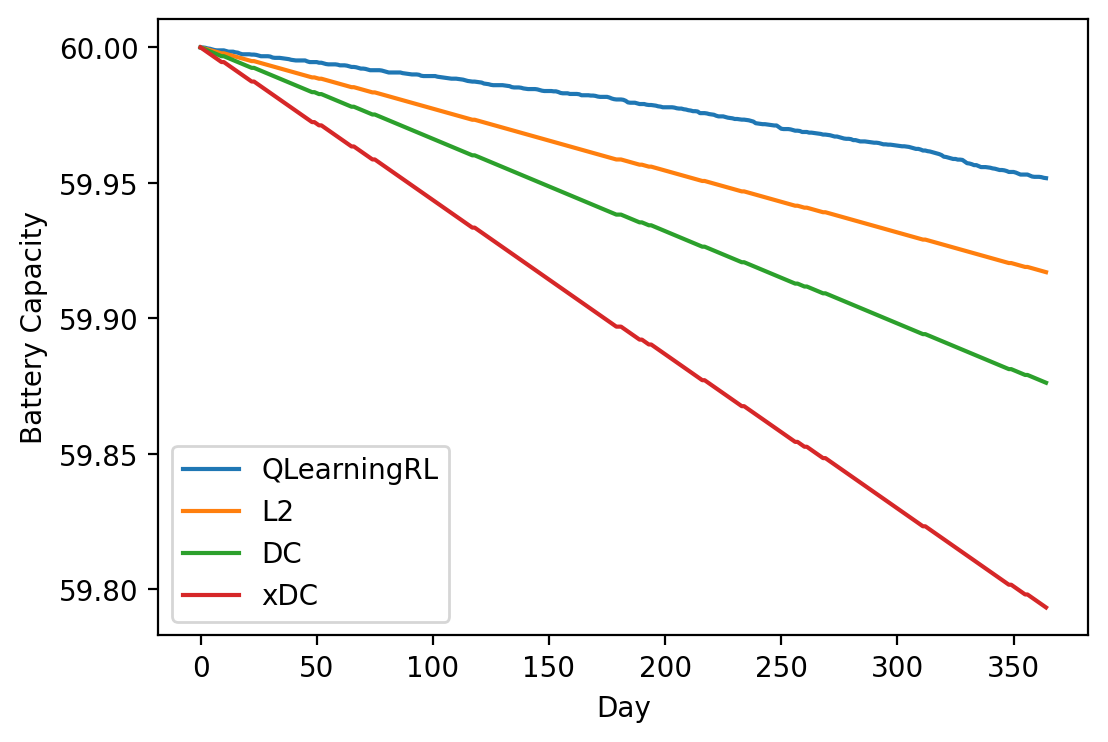

In [19]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(range(365), tank_size_list)
plt.plot(range(365), tank_size_list_L2)
plt.plot(range(365), tank_size_list_DC)
plt.plot(range(365), tank_size_list_xDC)
plt.legend(['QLearningRL','L2', 'DC', 'xDC'])
plt.xlabel('Day')
plt.ylabel('Battery Capacity')
plt.savefig('Battery Size Comparison RLvsNonRL 1208.png', bbox_inches="tight", dpi=200)

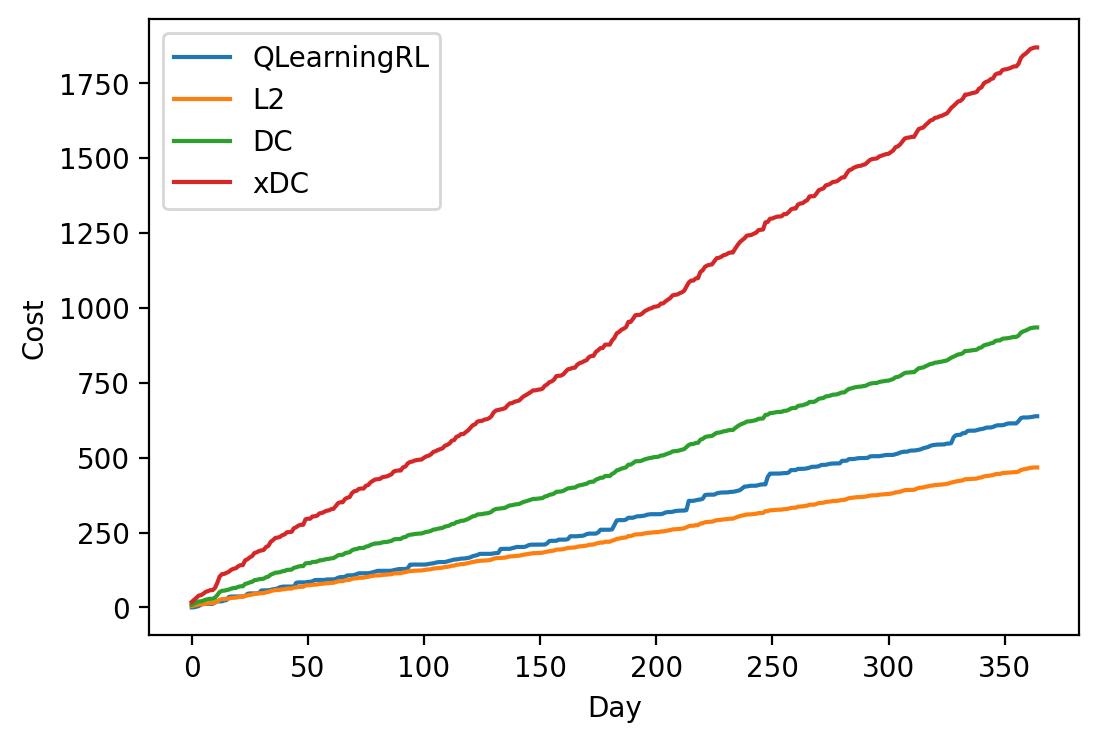

In [20]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(range(365), total_cost_list)
plt.plot(range(365), total_cost_list_L2)
plt.plot(range(365), total_cost_list_DC)
plt.plot(range(365), total_cost_list_xDC)
plt.legend(['QLearningRL','L2', 'DC', 'xDC'])
plt.xlabel('Day')
plt.ylabel('Cost')
plt.savefig('Cost Comparison RLvsNonRL 1208.png', bbox_inches="tight", dpi=200)

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame(data = my_dict['Cost'], columns=['RLCost'])
df['Day'] = list(range(1,366))
df['L2Cost'] = daily_cost_list_L2
df['DCCost'] = daily_cost_list_DC
df['xDCCost'] = daily_cost_list_xDC
df = df[['Day', 'RLCost', 'L2Cost', 'DCCost', 'xDCCost']]
df

,Day,RLCost,L2Cost,DCCost,xDCCost
0,1,0.000,4.575685,9.151370,18.302741
1,2,0.468,1.684981,3.369962,6.739924
2,3,1.976,1.784500,3.569000,7.138001
3,4,1.872,1.832483,3.664965,7.329930
4,5,4.940,0.332364,0.664728,1.329455
...,...,...,...,...,...
360,361,0.000,1.799217,3.598435,7.196870
361,362,0.936,2.055943,4.111886,8.223772
362,363,0.988,0.717023,1.434047,2.868093
363,364,2.106,0.656360,1.312719,2.625438


In [16]:
monthly_cost_RL = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sept':0, 
                   'Oct':0, 'Nov':0, 'Dec':0}

j = 0

for item in monthly_cost_RL.keys():
    total_monthly_cost = 0
    if item in ['Jan', 'Mar', 'May', 'Jul', 'Aug', 'Oct', 'Nov']:
        a = 31
    elif item == 'Feb':
        a = 28
    else: 
        a = 30
    
    for i in range(a):
        total_monthly_cost += my_dict['Cost'][j+i] 
    j += i+1
    monthly_cost_RL[item] = total_monthly_cost
print(monthly_cost_RL)
    
    

{'Jan': 56.52176044928464, 'Feb': 36.58776731992497, 'Mar': 34.69974558381994, 'Apr': 37.35671251390427, 'May': 44.38108739732781, 'Jun': 49.80369709867283, 'Jul': 63.90556396580558, 'Aug': 82.81037540879997, 'Sept': 69.82092705392789, 'Oct': 35.52611698485829, 'Nov': 77.38749945465011, 'Dec': 49.15484912509139}


In [17]:
monthly_cost_L2 = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sept':0, 
                   'Oct':0, 'Nov':0, 'Dec':0}
monthly_cost_DC = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sept':0, 
                   'Oct':0, 'Nov':0, 'Dec':0}
monthly_cost_xDC = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sept':0, 
                   'Oct':0, 'Nov':0, 'Dec':0}


j = 0

for item in monthly_cost_L2.keys():
    total_monthly_cost = 0
    if item in ['Jan', 'Mar', 'May', 'Jul', 'Aug', 'Oct', 'Nov']:
        a = 31
    elif item == 'Feb':
        a = 28
    else: 
        a = 30
    
    for i in range(a):
        total_monthly_cost += daily_cost_list_L2[j+i] 
    j += i+1
    monthly_cost_L2[item] = total_monthly_cost
print(monthly_cost_L2)


{'Jan': 47.55971775054931, 'Feb': 33.05513526916504, 'Mar': 33.608565597534174, 'Apr': 33.491538124084464, 'May': 34.17827419281007, 'Jun': 37.362196578979486, 'Jul': 43.60026922225952, 'Aug': 48.939220657348635, 'Sept': 37.79922328948975, 'Oct': 34.33282871246338, 'Nov': 43.991208229064945, 'Dec': 39.238541450500485}


In [18]:
monthly_cost_DC = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sept':0, 
                   'Oct':0, 'Nov':0, 'Dec':0}
monthly_cost_xDC = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'Jun':0, 'Jul':0, 'Aug':0, 'Sept':0, 
                   'Oct':0, 'Nov':0, 'Dec':0}


j = 0

for item in monthly_cost_DC.keys():
    total_monthly_cost = 0
    if item in ['Jan', 'Mar', 'May', 'Jul', 'Aug', 'Oct', 'Nov']:
        a = 31
    elif item == 'Feb':
        a = 28
    else: 
        a = 30
    
    for i in range(a):
        total_monthly_cost += daily_cost_list_DC[j+i] 
    j += i+1
    monthly_cost_DC[item] = total_monthly_cost
print(monthly_cost_DC)


{'Jan': 95.11943550109862, 'Feb': 66.11027053833008, 'Mar': 67.21713119506835, 'Apr': 66.98307624816893, 'May': 68.35654838562014, 'Jun': 74.72439315795897, 'Jul': 87.20053844451904, 'Aug': 97.87844131469727, 'Sept': 75.5984465789795, 'Oct': 68.66565742492676, 'Nov': 87.98241645812989, 'Dec': 78.47708290100097}


In [19]:
monthly_cost_xDC = {'Jan':[], 'Feb':[], 'Mar':[], 'Apr':[], 'May':[], 'Jun':[], 'Jul':[], 'Aug':[], 'Sept':[], 
                   'Oct':[], 'Nov':[], 'Dec':[]}


j = 0

for item in monthly_cost_xDC.keys():
    total_monthly_cost = 0
    if item in ['Jan', 'Mar', 'May', 'Jul', 'Aug', 'Oct', 'Nov']:
        a = 31
    elif item == 'Feb':
        a = 28
    else: 
        a = 30
    
    for i in range(a):
        total_monthly_cost += daily_cost_list_xDC[j+i] 
    j += i+1
    monthly_cost_xDC[item] = total_monthly_cost
print(monthly_cost_xDC)


{'Jan': 190.23887100219724, 'Feb': 132.22054107666017, 'Mar': 134.4342623901367, 'Apr': 133.96615249633786, 'May': 136.7130967712403, 'Jun': 149.44878631591794, 'Jul': 174.40107688903808, 'Aug': 195.75688262939454, 'Sept': 151.196893157959, 'Oct': 137.33131484985353, 'Nov': 175.96483291625978, 'Dec': 156.95416580200194}


In [20]:
new_df = pd.DataFrame(data = monthly_cost_RL.values(), columns=['RL Monthly Cost'])
new_df['Month'] = monthly_cost_RL.keys()
new_df['L2 Monthly Cost'] = monthly_cost_L2.values()
new_df['DC Monthly Cost'] = monthly_cost_DC.values()
new_df['xDC Monthly Cost'] = monthly_cost_xDC.values()
new_df = new_df[['Month','RL Monthly Cost','L2 Monthly Cost','DC Monthly Cost','xDC Monthly Cost']]
new_df

,Month,RL Monthly Cost,L2 Monthly Cost,DC Monthly Cost,xDC Monthly Cost
0,Jan,56.521760,47.559718,95.119436,190.238871
1,Feb,36.587767,33.055135,66.110271,132.220541
2,Mar,34.699746,33.608566,67.217131,134.434262
3,Apr,37.356713,33.491538,66.983076,133.966152
4,May,44.381087,34.178274,68.356548,136.713097
5,Jun,49.803697,37.362197,74.724393,149.448786
6,Jul,63.905564,43.600269,87.200538,174.401077
7,Aug,82.810375,48.939221,97.878441,195.756883
8,Sept,69.820927,37.799223,75.598447,151.196893
9,Oct,35.526117,34.332829,68.665657,137.331315


In [21]:
new_df1 = new_df.set_index('Month')
new_df1.index

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec'],
      dtype='object', name='Month')

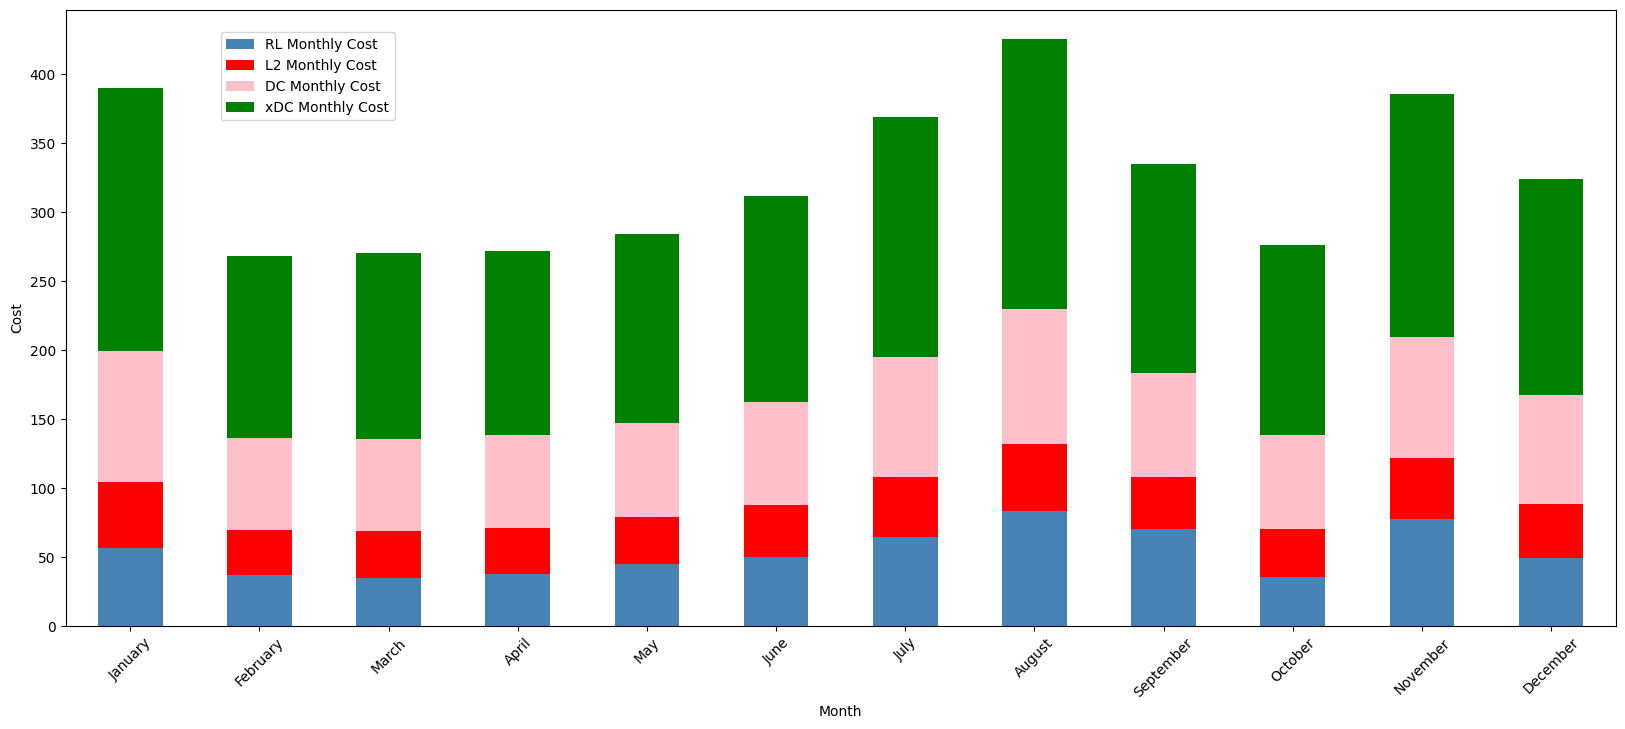

In [22]:
#create stacked bar chart
new_df1.plot(kind='bar', stacked=True, color=['steelblue', 'red', 'pink', 'green'], figsize=(20,8))
#add axis titles
plt.xlabel('Month')
plt.ylabel('Cost')

#rotate x-axis labels
plt.xticks(ticks=list(range(12)),labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December'], rotation=45)
plt.legend(loc=(0.1,0.82))
#plt.savefig('DailyCostComparison1408.png', bbox_inches="tight", dpi=200);

In [23]:
melted_new_df = new_df.melt(id_vars = 'Month', value_vars=['RL Monthly Cost', 'L2 Monthly Cost', 'DC Monthly Cost', 'xDC Monthly Cost'])
melted_new_df

,Month,variable,value
0,Jan,RL Monthly Cost,56.521760
1,Feb,RL Monthly Cost,36.587767
2,Mar,RL Monthly Cost,34.699746
3,Apr,RL Monthly Cost,37.356713
4,May,RL Monthly Cost,44.381087
5,Jun,RL Monthly Cost,49.803697
6,Jul,RL Monthly Cost,63.905564
7,Aug,RL Monthly Cost,82.810375
8,Sept,RL Monthly Cost,69.820927
9,Oct,RL Monthly Cost,35.526117


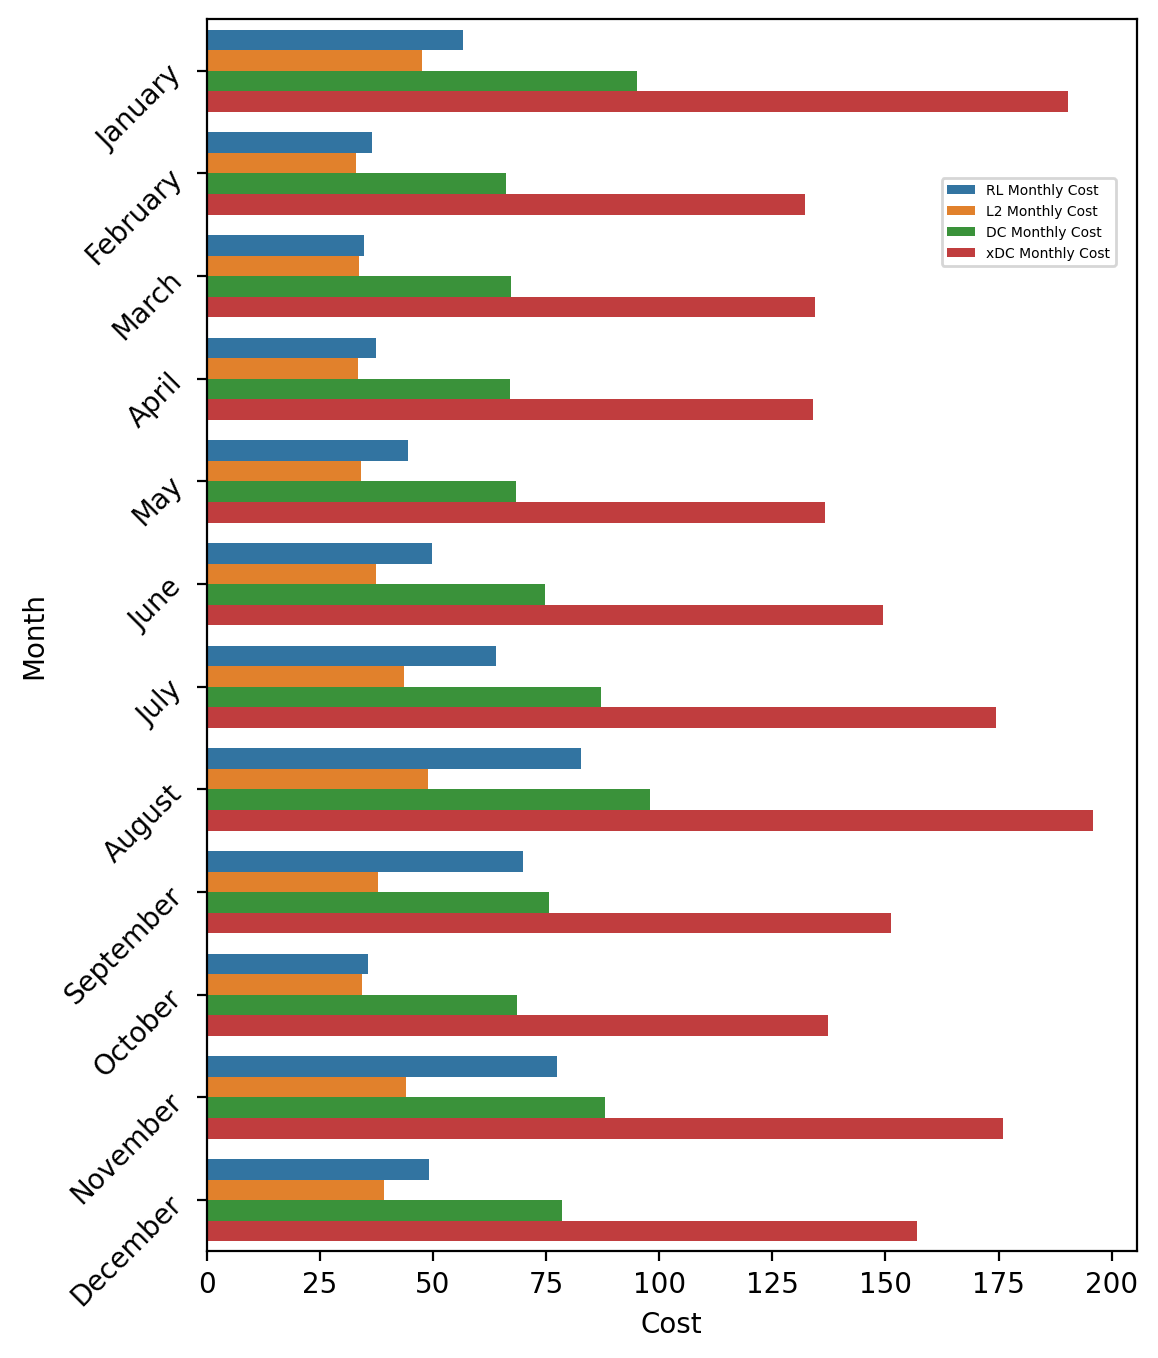

In [40]:
plt.figure(figsize=(6,8),dpi=200)
sns.barplot(melted_new_df, y='Month', x='value', hue='variable', orient='h')
plt.yticks(ticks=list(range(12)),labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December'], rotation=45)
plt.legend(loc=(0.79,0.8), prop={'size': 5})
plt.ylabel('Month')
plt.xlabel('Cost')
plt.savefig('MonthlyCostComparisonHorizontal1508.png', bbox_inches="tight", dpi=200)